# Ternausnet 16 Training

## Introduction

Useful links

* https://medium.datadriveninvestor.com/unet-for-semantic-segmentation-implementation-from-scratch-26e043fdcffa
* https://github.com/raoofnaushad/UNET_SALT_DETECTION
* https://keras.io/api/metrics/

### Connecting to the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing libraries

In [ ]:
!python --version

Python 3.10.12


In [ ]:
import os
import numpy as np
import time
import gc #garbage collector
import random
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm #progress bar
from PIL import Image
from datetime import datetime
from skimage.transform import resize

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Precision, Recall, SensitivityAtSpecificity, SpecificityAtSensitivity, MeanIoU
from tensorflow.keras import Model, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import plot_model

## Configurations

### Environment variables

In [ ]:
TASK = 1

if TASK == 1:
  os.environ["DATASET_PATH"] = "/content/drive/MyDrive/skin_cancer/assets/true_dataset/img_dataset/numpy_dataset/"
  os.environ["TASK"] = "task_1_lesion_segmentation"
  os.environ["NUMBER_OF_CLASSES"] = "1"

  os.environ["TRAINING_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1_Training_GroundTruth")
  os.environ["VALIDATION_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1_Validation_GroundTruth")
  os.environ["TEST_MASKS_PATH"] = str(os.environ["DATASET_PATH"] +  "ISIC2018_Task1_Test_GroundTruth")
elif TASK == 2:
  os.environ["DATASET_PATH"] = "/content/drive/MyDrive/skin_cancer/assets/true_dataset/data_aug_dataset/numpy_dataset/"
  os.environ["TASK"] = "task_2_lesion_attribute_detection"
  os.environ["NUMBER_OF_CLASSES"] = "5"

  os.environ["TRAINING_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task2_Training_GroundTruth_v3")
  os.environ["VALIDATION_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task2_Validation_GroundTruth")
  os.environ["TEST_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task2_Test_GroundTruth")

if TASK in [1, 2]:
  os.environ["TRAINING_IMAGES_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1-2_Training_Input")
  os.environ["VALIDATION_IMAGES_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1-2_Validation_Input")
  os.environ["TEST_IMAGES_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1_and_2_Test_Input")

  os.environ["VALIDATION_COUNT"] = "100"
  os.environ["TRAINING_COUNT"] = "2594"
  os.environ["TEST_COUNT"] = "1000"

### Global variables

In [ ]:
IM_HEIGHT = 256
IM_WIDTH = 256

## Data preparation

### Loading images

In [ ]:
TRAINING_IMAGES = np.load(os.environ["TRAINING_IMAGES_PATH"] + "/ISIC2018_Task1-2_Training_Input.npy")
TRAINING_MASKS = np.load(os.environ["TRAINING_MASKS_PATH"] + "/ISIC2018_Task1_Training_GroundTruth.npy")

VALIDATION_IMAGES = np.load(os.environ["VALIDATION_IMAGES_PATH"] + "/ISIC2018_Task1-2_Validation_Input.npy")
VALIDATION_MASKS = np.load(os.environ["VALIDATION_MASKS_PATH"] + "/ISIC2018_Task1_Validation_GroundTruth.npy")

print(f"No of images in the training - TRAINING_IMAGES: {len(TRAINING_IMAGES)} y: {len(TRAINING_MASKS)}")
print(f"No of images in the validation - x: {len(VALIDATION_IMAGES)} y: {len(VALIDATION_MASKS)}")

No of images in the training - TRAINING_IMAGES: 2594 y: 2594
No of images in the validation - x: 100 y: 100


### Plotting image

Random Sample Index is: 779


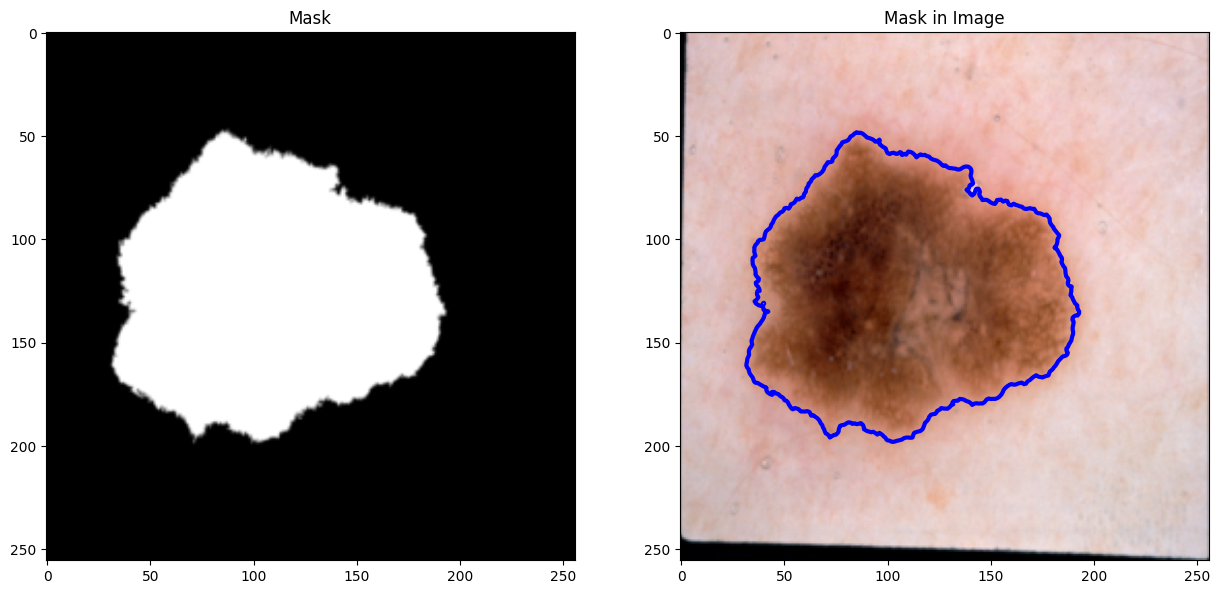

In [ ]:
## Plotting Sample Data

def plot_sample_example():
    ix = random.randint(0, len(TRAINING_IMAGES))
    print(f"Random Sample Index is: {ix}")
    has_mask = TRAINING_MASKS[ix].max() > 0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))

    ax1.imshow(TRAINING_MASKS[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
    ax1.set_title('Mask')

    ax2.imshow((TRAINING_IMAGES[ix]).squeeze())

    if has_mask:
        ax2.contour(TRAINING_MASKS[ix].squeeze(), colors = 'blue', linewidths = 3, levels = [0.5])
    ax2.set_title('Mask in Image')

plot_sample_example()

## Model

### Defining the model (U-net)

In [ ]:
## 2D two Convolution layer block
def Conv2D_block(input_tensor, n_filters, kernel_size, batchnorm): #Function to add 2 convolutional layers
    #Convolution layer - 1
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(input_tensor)
    #batchnormalization
    if batchnorm:
        x = BatchNormalization()(x)
    #Activation
    x = Activation('relu')(x)

    #Convolution layer - 2
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(x)
    #batchnormalization
    if batchnorm:
        x = BatchNormalization()(x)
    #Activation
    x = Activation('relu')(x)

    return x

In [ ]:
#Unet Architecture
def unet(input_image, n_filters=16, kernel_size=3, dropout=0.1, batchnorm=False):
    #Encoder Path || Contractor Path
    c1 = Conv2D_block(input_image, n_filters, kernel_size = kernel_size, batchnorm = batchnorm)
    p1 = MaxPooling2D((2,2))(c1)
    # p1 = Dropout(dropout)(p1)

    c2 = Conv2D_block(p1, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    # p2 = Dropout(dropout)(p2)

    c3 = Conv2D_block(p2, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    # p3 = Dropout(dropout)(p3)

    c4 = Conv2D_block(p3, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    # p4 = Dropout(dropout)(p4)

    c5 = Conv2D_block(p4, n_filters * 16, kernel_size = kernel_size, batchnorm = batchnorm)


    #Decoder Path  || Expansion Path
    u6 = Conv2DTranspose(n_filters * 8, (kernel_size, kernel_size), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    # u6 = Dropout(dropout)(u6)
    c6 = Conv2D_block(u6, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (kernel_size, kernel_size), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    # u7 = Dropout(dropout)(u7)
    c7 = Conv2D_block(u7, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (kernel_size, kernel_size), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    # u8 = Dropout(dropout)(u8)
    c8 = Conv2D_block(u8, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters, (kernel_size, kernel_size), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    # u9 = Dropout(dropout)(u9)
    c9 = Conv2D_block(u9, n_filters, kernel_size = kernel_size, batchnorm = batchnorm)

    #final 1*1 Convolutional layer
    output = Conv2D(1, (1,1), activation='sigmoid')(c9)
    model = Model(inputs=[input_image], outputs=[output])
    return model

### Defining the model (Ternausnet)

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters, kernel_size=2):
    x = Conv2DTranspose(num_filters, (kernel_size, kernel_size), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
#Unet Architecture --https://idiotdeveloper.com/vgg16-unet-implementation-in-tensorflow/
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

def build_ternausnet_unet(input_img, num_filters=16, kernel_size=3, dropout=0.2, batchnorm=True):
    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=input_img)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output ## (64 x 64)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512) ## (64 x 64)
    d2 = decoder_block(d1, s3, 256) ## (128 x 128)
    d3 = decoder_block(d2, s2, 128) ## (256 x 256)
    d4 = decoder_block(d3, s1, 64) ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs=[input_img], outputs=[outputs], name="VGG16_U-Net")
    return model

## Defining the metrics

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)

  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred): #Jaccard
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

  return intersection/union

def specificity(y_true, y_pred):
  true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
  possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))

  return true_negatives / (possible_negatives + K.epsilon())

## Training

In [ ]:
#Instantiate Keras tensor
input_img = Input((IM_HEIGHT, IM_WIDTH, 3), name='img')
metrics=[Accuracy(), Precision(), Recall(), iou, specificity, dice_coef]

#initialize params
n_filters = 32
kernel_size = 5
dropout = 0.1
batch_size = 32
epochs = 20
optimizer = Adam()

#CallBacks
call_backs = [
    # EarlyStopping(patience=10, verbose=1), #prevents overfitting or unnecessary training
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(f'/content/drive/MyDrive/skin_cancer/models/unet/weights/new_unet_{n_filters}_{kernel_size}_{batch_size}_{epochs}_vgg16.h5', verbose=1, save_best_only=True, save_weights_only=True) #saves the model
]

### Dataset Partitioning for Training and Testing

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(TRAINING_IMAGES, TRAINING_MASKS, test_size=0.2)

start = datetime.now()

# create model
model = build_ternausnet_unet(input_img, num_filters=n_filters, kernel_size=kernel_size, dropout=dropout)

# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

# Fit the model
results = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=call_backs, validation_data=(X_val, y_val))

K.clear_session()
gc.collect()

print(f"time: {datetime.now() - start}")

### K-Fold Cross-Validation

In [ ]:
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# # kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7) https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

# kf = KFold(n_splits = 5)

# loss_scores = []
# precision_scores = []
# iou_scores = []
# recall_scores = []
# specificity_score = []
# dice_coef_scores = []

# for train_idx, val_idx in list(kf.split(TRAINING_IMAGES, TRAINING_MASKS)):
#   X_train, X_val = TRAINING_IMAGES[train_idx], TRAINING_IMAGES[val_idx]
#   y_train, y_val = TRAINING_MASKS[train_idx], TRAINING_MASKS[val_idx]

#   # create model
#   model = unet(input_img, n_filters=n_filters, kernel_size=kernel_size, dropout=dropout, batchnorm=True)

#   # Compile model
#   model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

#   # Fit the model
#   results = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=call_backs, validation_data=(X_val, y_val))

#   loss = (results.history['loss'][-1])
#   precision = (results.history['precision'][-1])
#   recall = (results.history['recall'][-1])
#   iou = (results.history['iou'][-1])
#   specificity = (results.history['specificity'][-1])
#   dice_coef = (results.history['dice_coef'][-1])

#   print(f"loss: {loss}")
#   print(f"precision: {precision}")
#   print(f"recall: {recall}")
#   print(f"iou: {iou}")
#   print(f"specificity: {specificity}")
#   print(f"dice_coef: {dice_coef}")

#   loss_scores.append(loss)
#   precision_scores.append(precision)
#   recall_scores.append(recall)
#   iou_scores.append(iou)
#   specificity_score.append(specificity)
#   dice_coef_scores.append(dice_coef)

#   K.clear_session()
#   gc.collect()

#   del model
#   del X_train
#   del X_val
#   del y_train
#   del y_val
#   del results
#   del train_idx
#   del val_idx

# print(f"{np.mean(loss_scores)} (+/- {np.std(loss_scores)})")
# print(f"{np.mean(precision_scores)} (+/- {np.std(precision_scores)})")
# print(f"{np.mean(recall_scores)} (+/- {np.std(recall_scores)})")
# print(f"{np.mean(iou_scores)} (+/- {np.std(iou_scores)})")
# print(f"{np.mean(specificity_score)} (+/- {np.std(specificity_score)})")
# print(f"{np.mean(dice_coef_scores)} (+/- {np.std(dice_coef_scores)})")

In [ ]:
K.clear_session()
gc.collect()

## Results

In [ ]:
#Unet Jaccard
def plot_history(results):
    plt.figure(figsize=(8,8))
    plt.title("Jaccard Vs Epochs")
    plt.plot(results.history["iou"], label="iou")
    plt.plot(results.history["val_iou"], label="val_iou")
    plt.plot( np.argmax(results.history["val_iou"]), np.max(results.history["val_iou"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("Jaccard")
    plt.legend()

plot_history(results)
print(results.history["iou"])

In [ ]:
#Unet loss
def plot_history(results):
    plt.figure(figsize=(8,8))
    plt.title("Loss Vs Epochs")
    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend()

plot_history(results)
print(results.history["loss"])

In [ ]:
#Unet loss
def plot_history(results):
    plt.figure(figsize=(8,8))
    plt.title("Loss Vs Epochs")
    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.ylim([0, 1])
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend()

plot_history(results)

In [ ]:
#Unet Precision
def plot_history(results):
    plt.figure(figsize=(8,8))
    plt.title("Precision Vs Epochs")
    plt.plot(results.history["precision"], label="precision")
    plt.plot(results.history["val_precision"], label="val_precision")
    plt.plot(np.argmax(results.history["val_precision"]), np.max(results.history["val_precision"]), marker="x", color="r", label="best model")
    plt.ylim([0, 1])
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()

plot_history(results)
print(results.history["precision"])

In [ ]:
# Unet Specificity
def plot_history(results):
    plt.figure(figsize=(8,8))
    plt.title("Specificity Vs Epochs")
    plt.plot(results.history["specificity"], label="specificity")
    plt.plot(results.history["val_specificity"], label="val_specificity")
    plt.plot(np.argmax(results.history["val_specificity"]), np.max(results.history["val_specificity"]), marker="x", color="r", label="best model")
    plt.ylim([0, 1])
    plt.xlabel("Epochs")
    plt.ylabel("Specificity")
    plt.legend()

plot_history(results)
print(results.history["specificity"])

In [ ]:
#Unet DICE
def plot_history(results):
    plt.figure(figsize=(8,8))
    plt.title("DICE Vs Epochs")
    plt.plot(results.history["dice_coef"], label="dice_coef")
    plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
    plt.plot(np.argmax(results.history["val_dice_coef"]), np.max(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
    plt.ylim([0, 1])
    plt.xlabel("Epochs")
    plt.ylabel("DICE")
    plt.legend()

plot_history(results)
print(results.history["dice_coef"])

In [ ]:
#Unet Recall
def plot_history(results):
    plt.figure(figsize=(8,8))
    plt.title("Recall Vs Epochs")
    plt.plot(results.history["recall"], label="recall")
    plt.plot(results.history["val_recall"], label="val_recall")
    plt.plot(np.argmax(results.history["val_recall"]), np.max(results.history["val_recall"]), marker="x", color="r", label="best model")
    plt.ylim([0, 1])
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()

plot_history(results)
print(results.history["recall"])